In [3]:
import xarray as xr
import pandas as pd
import numpy as np
import calendar as cld
import matplotlib.pyplot as plt
import matplotlib.colors
colors_land = plt.cm.terrain(np.linspace(0.25, 1, 256))
import proplot as pplt # New plot library (https://proplot.readthedocs.io/en/latest/)
pplt.rc['savefig.dpi'] = 300 # 1200 is too big! #https://proplot.readthedocs.io/en/latest/basics.html#Creating-figures
from scipy.stats import chi2
from numba import njit,prange
import matplotlib as mpl
mpl.rcParams['hatch.linewidth'] = 0.05  # previous pdf hatch linewidth
from matplotlib.dates import DateFormatter

In [14]:
# function for seasonal mean (from Ian)
def season_mean(ds, calendar="standard"):
    #make a DataArray with the season of each day
    seas_array = ds.time.dt.season
    
    # count days in winter season (varies with leap years)
    nb_DJF = seas_array.str.count('DJF').sum()
    
    wgt_DJF = 1/nb_DJF.values.item()
    wgt_MAM = 1/(31+30+31)
    wgt_JJA = 1/(30+31+31)
    wgt_SON = 1/(30+31+30)

    weight = seas_array.str.replace('DJF',str(wgt_DJF)).str.replace('MAM',str(wgt_MAM)).str.replace('JJA',str(wgt_JJA)).str.replace('SON',str(wgt_SON))
    weight = weight.astype('float')
    
    # Test that the sum of the weights for each season is 1.0
    np.testing.assert_allclose(weight.groupby("time.season").sum().values, np.ones(4))

    # Calculate the weighted average
    return (ds * weight).groupby("time.season").sum(dim="time")

In [5]:
normal_format = {'gridlinewidth':0.1, 'gridcolor':'gray8', 'gridalpha':0.5, 'coast':True,'borders':True ,'reso':'hi', 'labels':True, 'lonlines':2, 'latlines':2, 'abc':False, 'latlim':[43.,48.5],'lonlim':[4.,16.]}
multiplot_format = {'gridlinewidth':0.1, 'gridcolor':'gray8', 'gridalpha':0.5, 'coast':True,'borders':True ,'reso':'hi', 'labels':False, 'lonlines':2, 'latlines':2, 'abc':False, 'latlim':[43.,48.5],'lonlim':[4.,16.]}

imin = 32 ; imax = -30
jmin = 20 ; jmax = -15
ds = xr.open_dataset('/bettik/beaumetj/MARout/MAR-EC-Earth3/MARgrid_EUe.nc')
lon = np.array(ds.LON[jmin:jmax,imin:imax])
lat = np.array(ds.LAT[jmin:jmax,imin:imax])
H = np.array(ds.SH[jmin:jmax,imin:imax])
nlat,nlon = 91, 139

In [16]:
first_year = 1985
last_year = 2014
for year in list(range(first_year,last_year+1)):
    print(year,end=' ')
    ds_T = xr.open_dataset('/bettik/beaumetj/MARout/MAR-EC-Earth3/HIST/daily/ICE.EC-Earth3_HIST.EUe.TTz.'+str(year)+'.nc')
    seasonal_mean_year=season_mean(ds_T.TTz.sel(ztqlev=2)).sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season']))
    ds_Tmax = xr.open_dataset('/bettik/beaumetj/MARout/MAR-EC-Earth3/HIST/daily/ICE.EC-Earth3_HIST.EUe.TTmax.'+str(year)+'.nc')
    seasonal_max_year=(ds_Tmax.TTmax.isel(atmlay=0)).groupby("time.season").max(dim="time").sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season']))

    if year> first_year:
        seasonal_mean += seasonal_mean_year
        seasonal_max += seasonal_max_year
    else:
        seasonal_mean = xr.DataArray.copy(seasonal_mean_year)
        seasonal_max = xr.DataArray.copy(seasonal_max_year)
seasonal_mean /= (last_year-first_year+1)
seasonal_max /= (last_year-first_year+1)

print(seasonal_mean.shape, seasonal_mean.season.data)

1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 (4, 126, 201) ['DJF' 'MAM' 'JJA' 'SON']


In [18]:
first_year = 2071
last_year = 2100
for year in list(range(first_year,last_year+1)):
    print(year,end=' ')
    ds_T = xr.open_dataset('/bettik/beaumetj/MARout/MAR-EC-Earth3/SSP245/daily/ICE.EC-Earth3_SSP245.EUe.TTz.'+str(year)+'.nc')
    seasonal_mean_year=season_mean(ds_T.TTz.sel(ztqlev=2)).sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season']))
    ds_Tmax = xr.open_dataset('/bettik/beaumetj/MARout/MAR-EC-Earth3/SSP245/daily/ICE.EC-Earth3_SSP245.EUe.TTmax.'+str(year)+'.nc')
    seasonal_max_year=(ds_Tmax.TTmax.isel(atmlay=0)).groupby("time.season").max(dim="time").sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season']))
    
    if year> first_year:
        seasonal_mean_2100 += seasonal_mean_year
        seasonal_max_2100 += seasonal_max_year
    else:
        seasonal_mean_2100 = xr.DataArray.copy(seasonal_mean_year)
        seasonal_max_2100 = xr.DataArray.copy(seasonal_max_year)
seasonal_mean_2100 /= (last_year-first_year+1)
seasonal_max_2100 /= (last_year-first_year+1)

print(seasonal_mean_2100.shape, seasonal_mean_2100.season.data)

2071 2072 2073 2074 2075 2076 2077 2078 2079 2080 2081 2082 2083 2084 2085 2086 2087 2088 2089 2090 2091 2092 2093 2094 2095 2096 2097 2098 2099 2100 (4, 126, 201) ['DJF' 'MAM' 'JJA' 'SON']


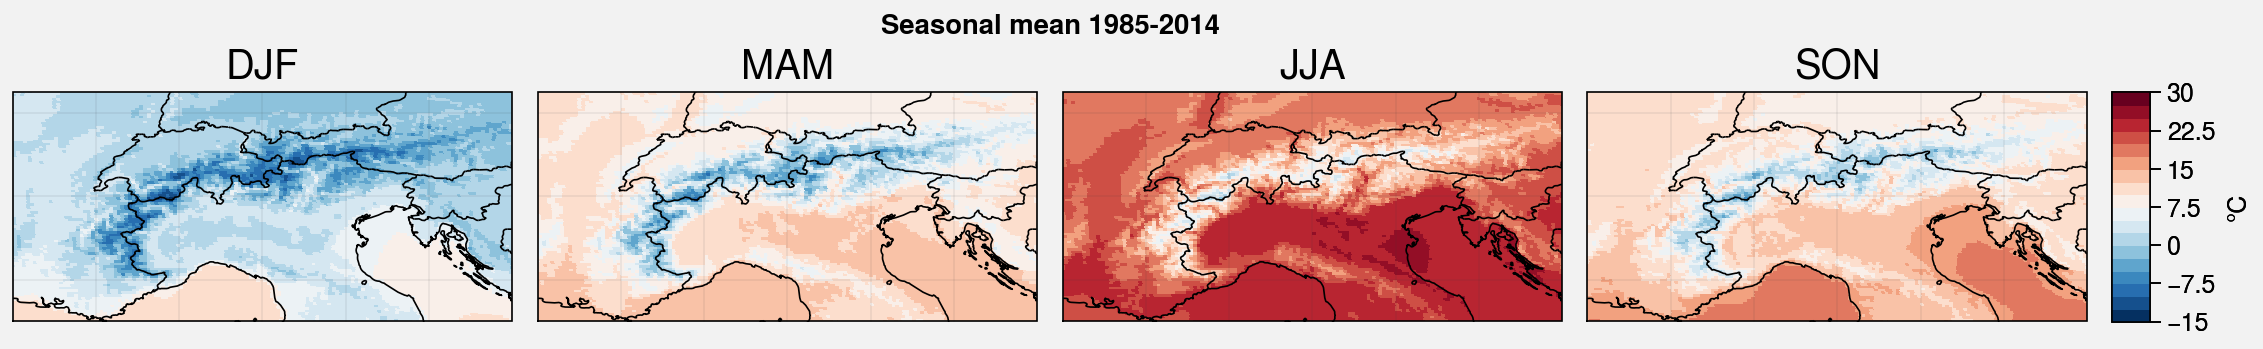

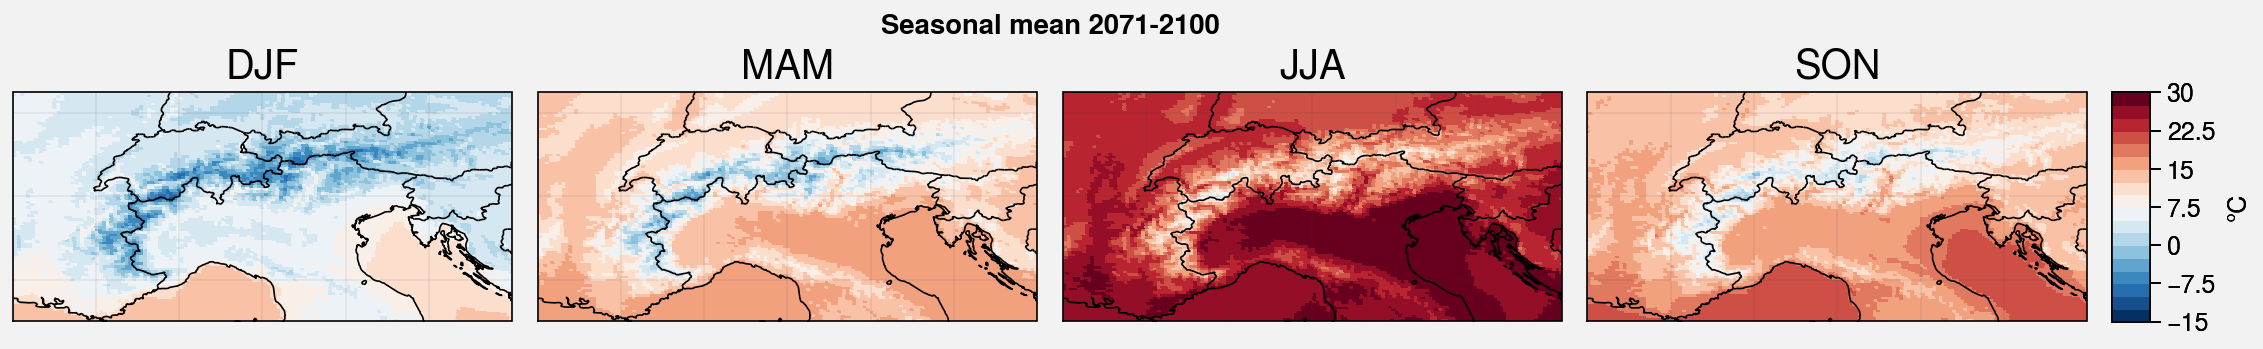

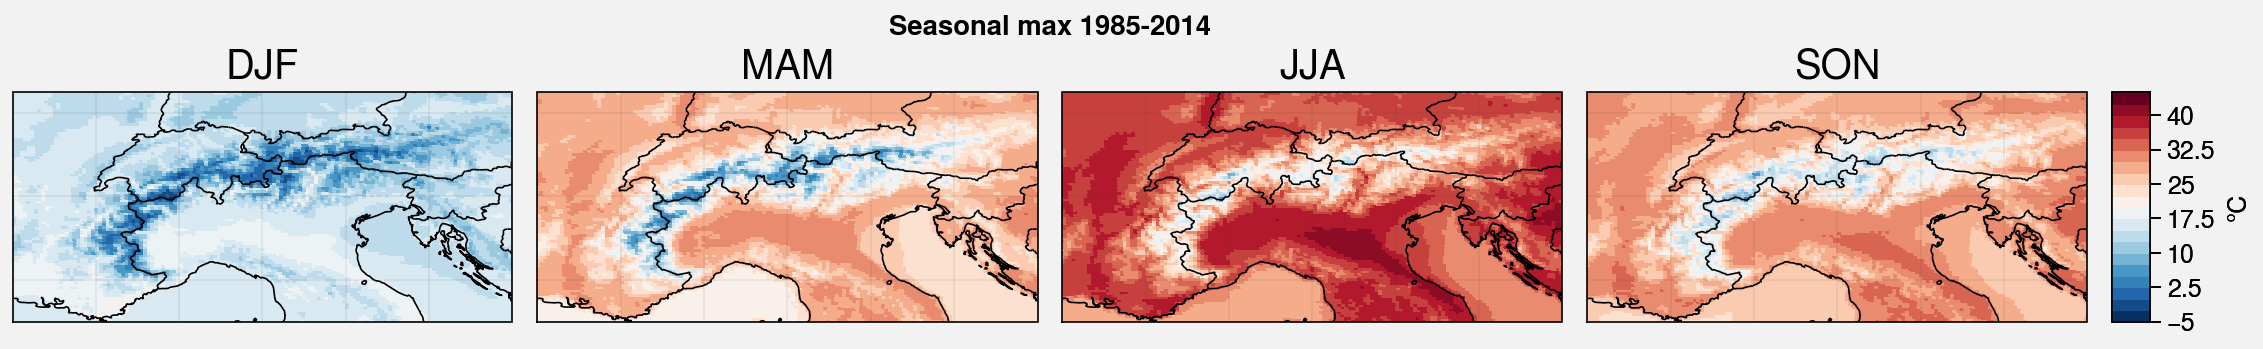

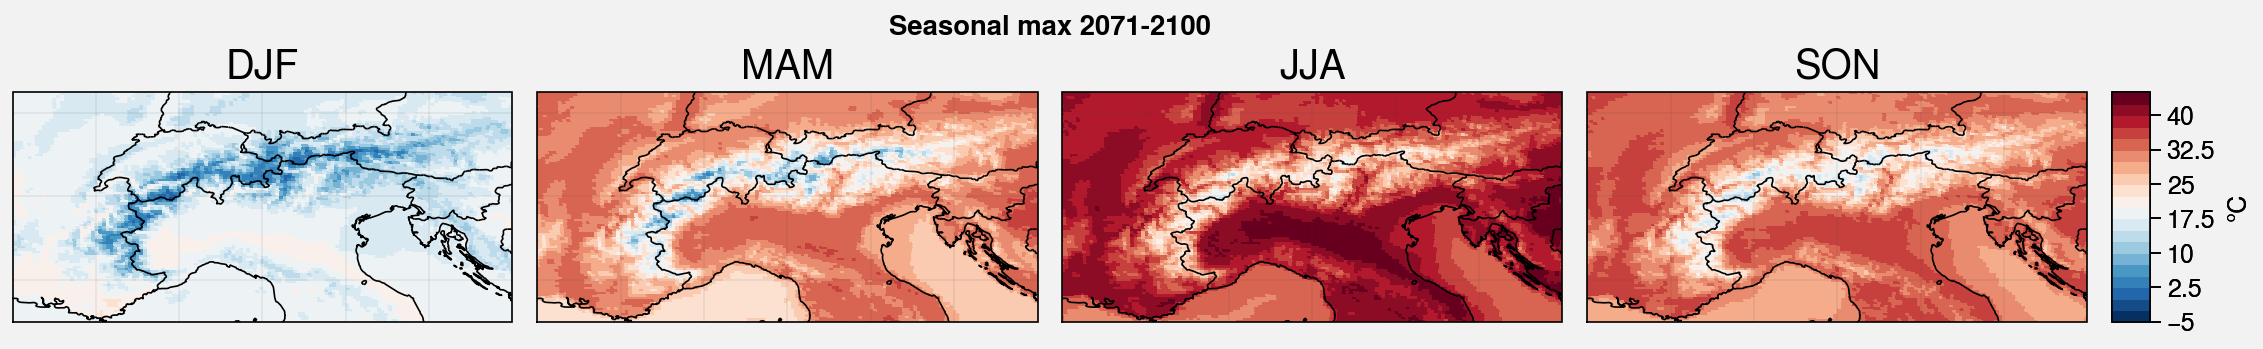

In [26]:
f, axs = pplt.subplots(proj='cyl',ncols=4)
for i, ax in enumerate(axs):
    m = ax.pcolormesh(ds.LON,ds.LAT,seasonal_mean[i,:,:],levels=np.linspace(-15,30,19),cmap='RdBu_r')
    ax.format(title=['DJF','MAM','JJA', 'SON'][i],titlesize='20px')
f.colorbar(m, label= '°C')

axs.format(**multiplot_format,suptitle="Seasonal mean 1985-2014")


f, axs = pplt.subplots(proj='cyl',ncols=4)
for i, ax in enumerate(axs):
    m = ax.pcolormesh(ds.LON,ds.LAT,seasonal_mean_2100[i,:,:],levels=np.linspace(-15,30,19),cmap='RdBu_r')
    ax.format(title=['DJF','MAM','JJA', 'SON'][i],titlesize='20px')
f.colorbar(m, label= '°C')

axs.format(**multiplot_format,suptitle="Seasonal mean 2071-2100")

f, axs = pplt.subplots(proj='cyl',ncols=4)
for i, ax in enumerate(axs):
    m = ax.pcolormesh(ds.LON,ds.LAT,seasonal_max[i,:,:],levels=np.linspace(-5,45,21),cmap='RdBu_r')
    ax.format(title=['DJF','MAM','JJA', 'SON'][i],titlesize='20px')
f.colorbar(m, label= '°C')

axs.format(**multiplot_format,suptitle="Seasonal max 1985-2014")


f, axs = pplt.subplots(proj='cyl',ncols=4)
for i, ax in enumerate(axs):
    m = ax.pcolormesh(ds.LON,ds.LAT,seasonal_max_2100[i,:,:],levels=np.linspace(-5,45,21),cmap='RdBu_r')
    ax.format(title=['DJF','MAM','JJA', 'SON'][i],titlesize='20px')
f.colorbar(m, label= '°C')

axs.format(**multiplot_format,suptitle="Seasonal max 2071-2100")

In [22]:
seasonal_max.max()

<xarray.DataArray 'TTmax' ()>
array(42.394547, dtype=float32)
Coordinates:
    atmlay   float32 0.9997

In [25]:
50/17

2.9411764705882355

In [12]:
season_max_year

<xarray.DataArray 'TTmax' (season: 4, y: 126, x: 201)>
array([[[15.610626 , 15.627075 , 15.650787 , ..., 14.871674 ,
         14.914886 , 15.049103 ],
        [15.720367 , 17.711761 , 18.397705 , ..., 14.995941 ,
         14.837952 , 14.887695 ],
        [15.325287 , 18.07904  , 19.310547 , ..., 14.956177 ,
         14.87146  , 14.799927 ],
        ...,
        [13.146179 , 12.847321 , 12.899597 , ...,  4.226013 ,
          3.9681702,  3.2339172],
        [13.184326 , 12.844971 , 12.865326 , ...,  5.065674 ,
          4.6008606,  3.1608582],
        [13.167603 , 13.226013 , 13.286591 , ...,  3.6342773,
          3.480713 ,  3.2033997]],

       [[22.13974  , 22.133575 , 22.131287 , ..., 21.764893 ,
         21.888824 , 22.081787 ],
        [22.150726 , 23.196075 , 23.44754  , ..., 21.284943 ,
         21.782623 , 22.04831  ],
        [21.566559 , 23.290771 , 24.642395 , ..., 21.033478 ,
         21.70279  , 22.041473 ],
...
        [26.672394 , 29.087646 , 31.700745 , ..., 30.984955 ,
         31.143127 , 28.57074  ],
        [26.160675 , 27.424225 , 28.861115 , ..., 32.58319  ,
         32.46826  , 28.427002 ],
        [25.726746 , 25.97345  , 26.21518  , ..., 28.471436 ,
         28.422607 , 28.313232 ]],

       [[25.708374 , 25.596283 , 25.525787 , ..., 27.50885  ,
         27.473297 , 26.786194 ],
        [25.892426 , 27.676758 , 28.015747 , ..., 27.286163 ,
         27.226624 , 26.707275 ],
        [25.59085  , 27.670929 , 27.828247 , ..., 27.061432 ,
         26.535522 , 26.73587  ],
        ...,
        [19.784302 , 21.96466  , 22.019989 , ..., 23.678223 ,
         24.171875 , 21.976807 ],
        [19.568024 , 20.744232 , 22.72995  , ..., 25.675568 ,
         25.390228 , 21.944336 ],
        [19.395874 , 19.687195 , 19.931915 , ..., 21.933594 ,
         21.930298 , 21.935303 ]]], dtype=float32)
Coordinates:
  * season   (season) object 'DJF' 'MAM' 'JJA' 'SON'
    atmlay   float32 0.9997
  * x        (x) float32 -483.0 -476.0 -469.0 -462.0 ... 896.0 903.0 910.0 917.0
  * y        (y) float32 -308.0 -301.0 -294.0 -287.0 ... 546.0 553.0 560.0 567.0

In [6]:
np.shape(lon)

(91, 139)

In [7]:
np.shape(lat)

(91, 139)